# Customer Segmentation and Recommendation System  
### TCS iON Industry Project  

**Objective:**  
To segment customers using machine learning techniques and generate personalized product recommendations using clustering and collaborative filtering.

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
data="/content/drive/MyDrive/Customer_Segmentation_TCS/customer_data.csv"
df=pd.read_csv(data,encoding='latin1')


##  Exploratory Data Analysis
Initial exploration is performed to understand dataset structure, data types, missing values, and statistical distribution.


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.shape

(541909, 8)

In [6]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The dataset shows highly skewed numerical features with missing identifiers, indicating the presence of high-value customers and noisy transactional data, requiring robust preprocessing.

## Data Cleaning and Preprocessing
This step handles duplicate records, missing values, and data type corrections to ensure data quality.


In [9]:
print(df.duplicated().sum())
df=df.drop_duplicates()
print(df.duplicated().sum())


5268
0


In [10]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135037
Country,0


In [11]:
for col in df.select_dtypes(include=['object']):
  blank_count=(df[col].str.strip()=='').sum()
  print(f"Column {col} has {blank_count} blank entries")

Column InvoiceNo has 0 blank entries
Column StockCode has 0 blank entries
Column Description has 0 blank entries
Column InvoiceDate has 0 blank entries
Column Country has 0 blank entries


In [12]:
for col in df.select_dtypes(include=[np.number]):
  zero_count=(df[col]==0).sum()
  print(f"Column {col} has {zero_count} zero values")

Column Quantity has 0 zero values
Column UnitPrice has 2510 zero values
Column CustomerID has 0 zero values


In [13]:
df['UnitPrice']=df['UnitPrice'].fillna(df['UnitPrice'].median())

In [14]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135037
Country,0


In [15]:
df=df.dropna(subset=['CustomerID'])

In [16]:
df['Description']=df['Description'].fillna('Unknown')

In [17]:
df[['CustomerID','Quantity','UnitPrice']]=df[['CustomerID','Quantity','UnitPrice']].astype(int)

In [18]:
df = df.drop(columns=['InvoiceNo'])

In [19]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [20]:
df['InvoiceMonth']=df['InvoiceDate'].dt.month
df['InvoiceDay']=df['InvoiceDate'].dt.day
df['InvoiceHour']=df['InvoiceDate'].dt.hour
df['InvoiceWeekday']=df['InvoiceDate'].dt.weekday

In [21]:
df['StockCode'].value_counts()

,count
StockCode,
85123A,2065
22423,1894
85099B,1659
47566,1409
84879,1405
...,...
90181A,1
90199B,1
90102,1


In [22]:
df['TotalProducts']=df.groupby('CustomerID')['StockCode'].transform('count')
df['UniqueProducts']=df.groupby('CustomerID')['StockCode'].transform('nunique')

In [23]:
df['TotalSpend']=df['Quantity']*df['UnitPrice']

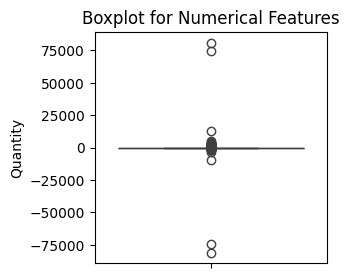

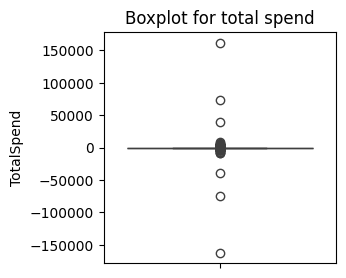

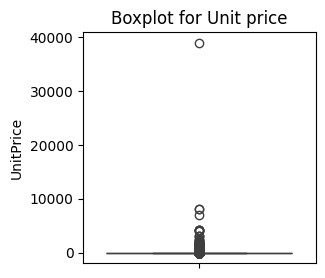

In [24]:
plt.figure(figsize=(3,3))
sns.boxplot(data=df['Quantity'])
plt.title("Boxplot for Numerical Features")
plt.show()


plt.figure(figsize=(3,3))
sns.boxplot(data=df['TotalSpend'])
plt.title("Boxplot for total spend")
plt.show()



plt.figure(figsize=(3,3))
sns.boxplot(data=df['UnitPrice'])
plt.title("Boxplot for Unit price")
plt.show()

Extreme and negative values represent real-world behaviors such as returns and VIP purchases, so outliers were retained and handled using RobustScaler instead of removal.

# **Feature Engineering**

In [25]:
#Reference date for recency
snapshot_date=df['InvoiceDate'].max()+pd.Timedelta(days=1)

In [26]:
# --- RFM Aggregation ---
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Quantity': 'sum',                                         # Frequency
    'TotalSpend': 'sum',                                       # Monetary
    'TotalProducts': 'max',
    'UniqueProducts': 'max',
    'InvoiceMonth': 'mean',
    'InvoiceWeekday': 'mean'
}).reset_index()

customer_df.rename(columns={'InvoiceDate':'Recency',
                             'Quantity':'Frequency',
                             'TotalSpend':'Monetary'}, inplace=True)
print(customer_df)

      CustomerID  Recency  Frequency  Monetary  TotalProducts  UniqueProducts  \
0          12346      326          0         0              2               1   
1          12347        2       2458      3012            182             103   
2          12348       75       2341       944             31              22   
3          12349       19        631      1404             73              73   
4          12350      310        197       244             17              17   
...          ...      ...        ...       ...            ...             ...   
4367       18280      278         45       142             10              10   
4368       18281      181         54        54              7               7   
4369       18282        8         98       130             13              12   
4370       18283        4       1357      1346            721             263   
4371       18287       43       1586      1136             70              59   

      InvoiceMonth  Invoice

RFM and product diversity features transform raw transactions into meaningful customer behavior profiles suitable for segmentation.

In [27]:
customer_df['Frequency'] = customer_df['Frequency'].clip(lower=0)
customer_df['Monetary']  = customer_df['Monetary'].clip(lower=0)


In [28]:
cols_to_use=['Recency','Frequency','Monetary','TotalProducts','UniqueProducts']
customer_log=np.log1p(customer_df[cols_to_use])
scaler=RobustScaler()
scaled_features=scaler.fit_transform(customer_log)


In [29]:
print(scaled_features)

[[ 0.89357383 -3.21473706 -3.47830322 -1.53676051 -1.8245913 ]
 [-1.36248761  1.03942032  1.09772057  0.85705964  0.66969162]
 [ 0.19183406  1.01285769  0.43536454 -0.15835086 -0.28282245]
 ...
 [-0.83416678 -0.71094738 -0.69339772 -0.63973752 -0.6429876 ]
 [-1.11683242  0.71590223  0.63784054  1.65630856  1.25775196]
 [-0.07099791  0.80081222  0.54102304  0.30572092  0.32246647]]


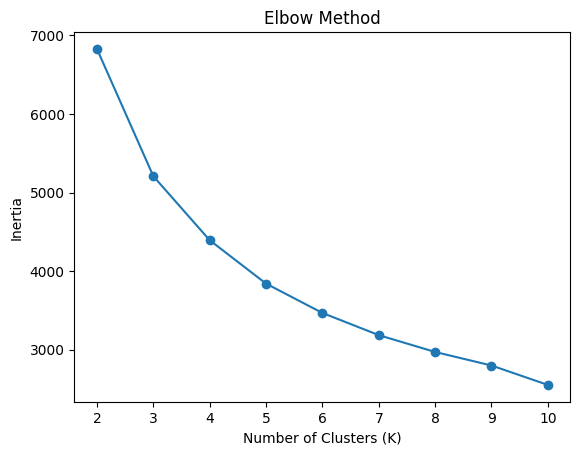

In [30]:
# Inertia is the sum of squared distances of each data point from its assigned cluster centroid.
# Lower inertia → points are closer to their centroids
# Higher inertia → High inertia means data points are far from their cluster centroids.
# As K increases, inertia always decreases (because more clusters fit data better)


# K = number of clusters (groups)
# Inertia = how tight the groups are
# Tight = how close the data points are to each other inside a cluster
#Low inertia means more points are closer to cluster

inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()



# Silhouette Score:
How well each data point fits inside its own cluster compared to other clusters.

K=2, Silhouette Score=0.392
K=3, Silhouette Score=0.307
K=4, Silhouette Score=0.289
K=5, Silhouette Score=0.248
K=6, Silhouette Score=0.249
K=7, Silhouette Score=0.229
K=8, Silhouette Score=0.246
K=9, Silhouette Score=0.245
K=10, Silhouette Score=0.240


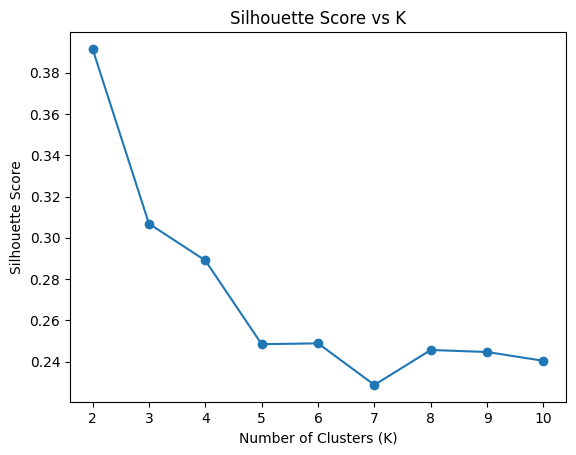

In [31]:
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.3f}")
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs K')
plt.show()
# Distance to your own group members → should be small
# Distance to other groups → should be large
# Silhouette = (b − a) / max(a, b)
# Score	Meaning
# +1	Perfect clustering
# ~0.5	Good clustering



## Davies-Bouldin-Index:
 How similar each cluster is to its nearest neighboring cluster.

K=2,Davies-Bouldin Index=0.927
K=3,Davies-Bouldin Index=1.075
K=4,Davies-Bouldin Index=1.118
K=5,Davies-Bouldin Index=1.179
K=6,Davies-Bouldin Index=1.173
K=7,Davies-Bouldin Index=1.212
K=8,Davies-Bouldin Index=1.170
K=9,Davies-Bouldin Index=1.126
K=10,Davies-Bouldin Index=1.096


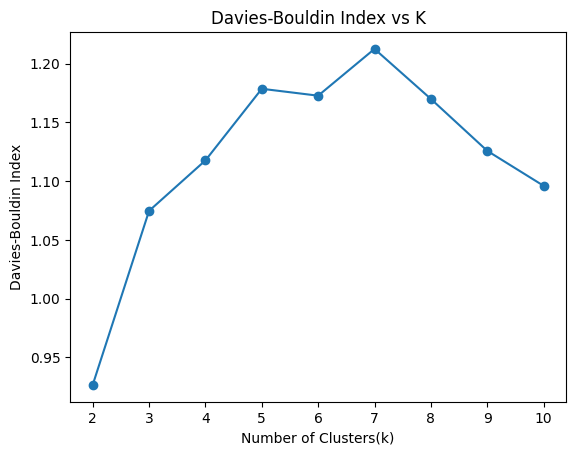

In [32]:
#Davies-BBouldin-Index
davies_score=[]
for k in range(2,11):
  kmeans=KMeans(n_clusters=k,random_state=42)
  labels=kmeans.fit_predict(scaled_features)
  db_score=davies_bouldin_score(scaled_features,labels)
  davies_score.append(db_score)
  print(f"K={k},Davies-Bouldin Index={db_score:.3f}")
plt.plot(range(2,11),davies_score,marker='o')
plt.xlabel("Number of Clusters(k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs K")
plt.show()



# **Calinski-Harabasz Index:**
Ratio of: Between-cluster separation to
Within-cluster compactness

K=2,Calinski-Harabasz Index=3838.337
K=3,Calinski-Harabasz Index=3194.278
K=4,Calinski-Harabasz Index=2794.013
K=5,Calinski-Harabasz Index=2553.148
K=6,Calinski-Harabasz Index=2355.737
K=7,Calinski-Harabasz Index=2201.027
K=8,Calinski-Harabasz Index=2067.134
K=9,Calinski-Harabasz Index=1953.126
K=10,Calinski-Harabasz Index=1950.610


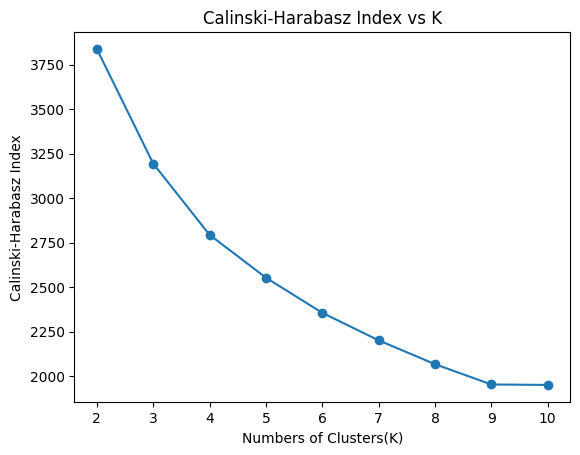

In [33]:
# ----- Calinski-Harabasz Index -----
calinski_scores=[]
for k in range(2,11):
  kmeans=KMeans(n_clusters=k,random_state=42)
  labels=kmeans.fit_predict(scaled_features)
  ch_score=calinski_harabasz_score(scaled_features,labels)
  calinski_scores.append(ch_score)
  print(f"K={k},Calinski-Harabasz Index={ch_score:.3f}")
plt.plot(range(2,11),calinski_scores,marker='o')
plt.xlabel("Numbers of Clusters(K)")
plt.ylabel("Calinski-Harabasz Index")
plt.title("Calinski-Harabasz Index vs K")
plt.show()


All evaluation metrics consistently indicate K = 3 as the optimal number of clusters, balancing statistical validity and business interpretability.

# **Customer Segmentation**
Customers are segmented using the K-Means clustering algorithm.


In [34]:
kmeans=KMeans(n_clusters=3,random_state=42)
kmeans.fit(scaled_features)
cluster_labels=kmeans.labels_
print(cluster_labels)

[0 2 1 ... 0 2 2]


In [35]:
customer_df

,CustomerID,Recency,Frequency,Monetary,TotalProducts,UniqueProducts,InvoiceMonth,InvoiceWeekday
0,12346,326,0,0,2,1,1.000000,1.000000
1,12347,2,2458,3012,182,103,7.598901,1.423077
2,12348,75,2341,944,31,22,8.290323,2.580645
3,12349,19,631,1404,73,73,11.000000,0.000000
4,12350,310,197,244,17,17,2.000000,2.000000
...,...,...,...,...,...,...,...,...
4367,18280,278,45,142,10,10,3.000000,0.000000
4368,18281,181,54,54,7,7,6.000000,6.000000
4369,18282,8,98,130,13,12,9.538462,3.769231
4370,18283,4,1357,1346,721,263,7.282940,2.296810


In [36]:
customer_df['Clusters']=cluster_labels
cluster_analysis=customer_df.groupby('Clusters').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'TotalProducts':'mean'

}).round(2)

In [37]:
# Customer Lifetime Value (CLV)
# -------------------------------
customer_df['CLV'] = (
    customer_df['Monetary'] * customer_df['Frequency']
) / (customer_df['Recency'] + 1)

customer_df['CLV'] = customer_df['CLV'].round(2)



In [38]:
clv_by_cluster = customer_df.groupby('Clusters')['CLV'].mean().round(2)
clv_by_cluster

,CLV
Clusters,
0,317.68
1,9847.12
2,24672973.65


In [39]:
db_index = davies_bouldin_score(scaled_features, cluster_labels)
ch_index = calinski_harabasz_score(scaled_features, cluster_labels)

customer_df['Silhouette_Score'] = round(silhouette_scores[1], 3) # index 1 is K=3 in your list
customer_df['DB_Index'] = round(db_index, 3)
customer_df['CH_Index'] = round(ch_index, 3)

print("Success! Metrics are now saved in your dataframe.")
print(f"DB Index: {db_index:.3f}")
print(f"CH Index: {ch_index:.3f}")

Success! Metrics are now saved in your dataframe.
DB Index: 1.075
CH Index: 3194.278


In [40]:
print(cluster_analysis)

          Recency  Frequency  Monetary  TotalProducts
Clusters                                             
0          168.66     172.89    138.82           9.74
1           95.55     410.23    479.49          43.45
2           28.00    2937.71   3569.21         229.35


Here

Clsuter 0    ---->very regualar,Loyal high-value customers

Clsuter 1   ------>Regular customers

Cluster 2---------->

## Cluster Profiling (Snake Plot)
Snake plots are used to compare standardized feature values across clusters.

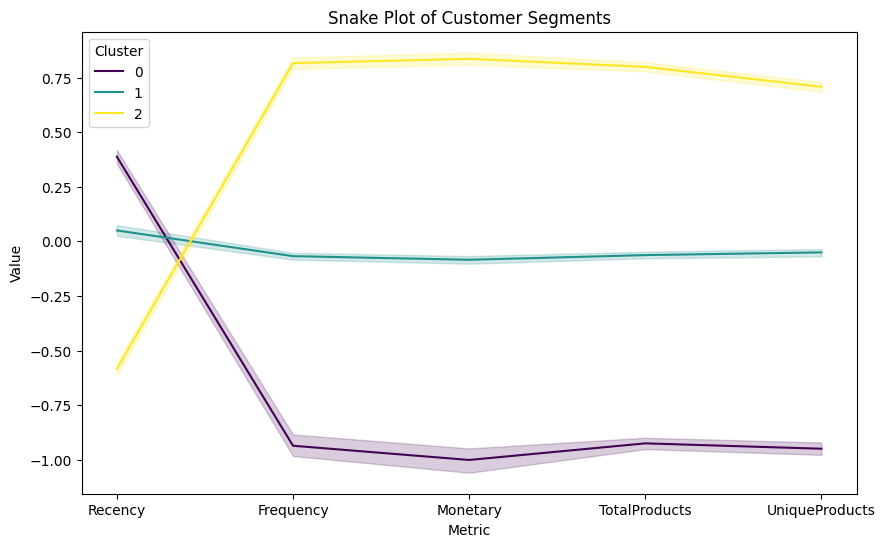

In [41]:
df_scaled = pd.DataFrame(scaled_features, columns=cols_to_use)

df_scaled['Cluster'] = cluster_labels
df_melt = pd.melt(df_scaled, id_vars=['Cluster'], value_vars=cols_to_use, var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melt, x='Metric', y='Value', hue='Cluster', palette='viridis')
plt.title('Snake Plot of Customer Segments')
plt.show()

Snake Plot:

At-Risk Customers: High recency with very low frequency and spending, indicating inactive customers who require re-engagement strategies.

Loyal High-Value Customers: Very low recency and high frequency and monetary values, representing recent, frequent, and high-spending customers.

Regular Customers: Values remain close to the dataset average across all metrics, reflecting stable but moderate purchasing behavior.

## Segment Profile Heatmap
A heatmap is used to visualize average behavioral patterns across customer segments.


In [42]:
cluster_names = {
    0: "Regular Customers",
    1: "Loyal High-Value Customers",
    2: "At-Risk Customers"
}
customer_df['Segment']=customer_df['Clusters'].map(cluster_names)
print(customer_df)

      CustomerID  Recency  Frequency  Monetary  TotalProducts  UniqueProducts  \
0          12346      326          0         0              2               1   
1          12347        2       2458      3012            182             103   
2          12348       75       2341       944             31              22   
3          12349       19        631      1404             73              73   
4          12350      310        197       244             17              17   
...          ...      ...        ...       ...            ...             ...   
4367       18280      278         45       142             10              10   
4368       18281      181         54        54              7               7   
4369       18282        8         98       130             13              12   
4370       18283        4       1357      1346            721             263   
4371       18287       43       1586      1136             70              59   

      InvoiceMonth  Invoice

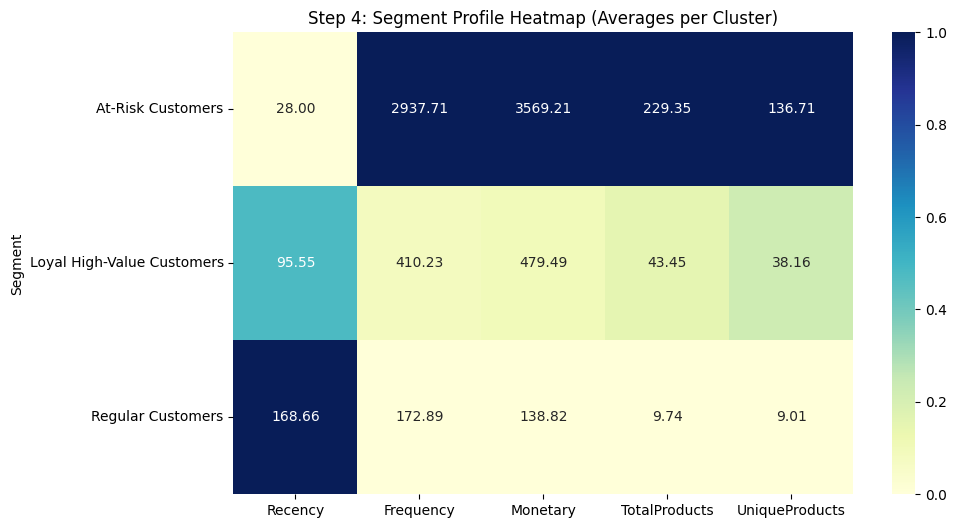

In [43]:
segment_profile = customer_df.groupby('Segment')[cols_to_use].mean()

segment_profile_normalized = (segment_profile - segment_profile.min()) / (segment_profile.max() - segment_profile.min())

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(segment_profile_normalized, annot=segment_profile, fmt=".2f", cmap="YlGnBu")
plt.title('Step 4: Segment Profile Heatmap (Averages per Cluster)')
plt.show()

The heatmap highlights clear behavioral differences across segments, with Loyal High-Value customers showing the highest frequency and monetary contribution, Regular customers exhibiting balanced averages, and At-Risk customers displaying high recency with low engagement.

## PCA Visualization
Principal Component Analysis is applied to visualize clusters in two dimensions.


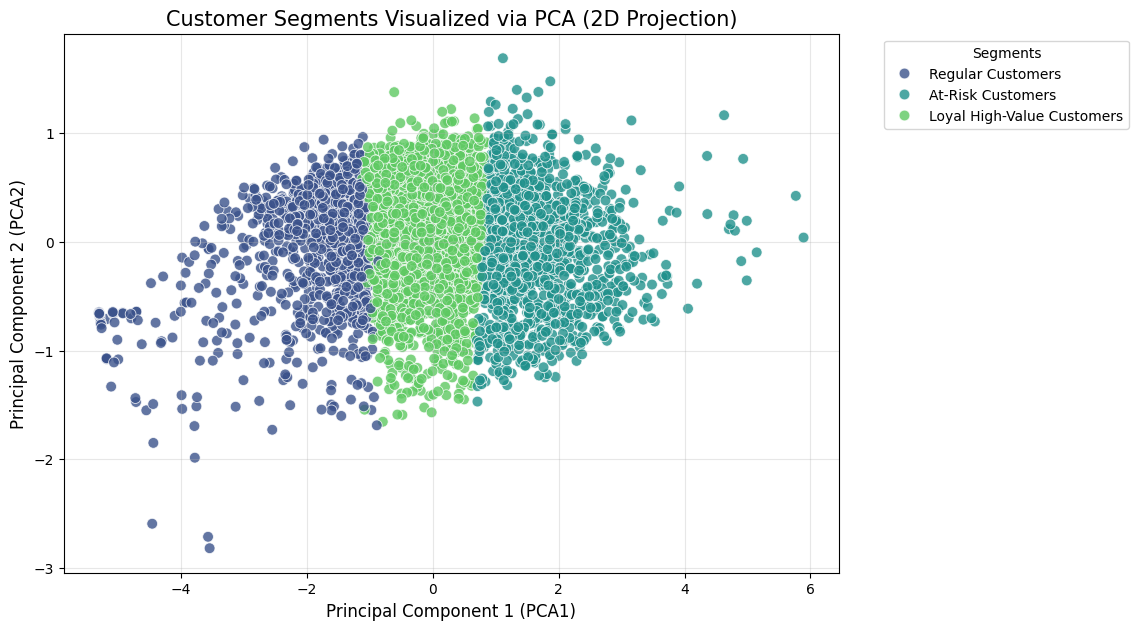

PCA 1 explains 75.55% of the data
PCA 2 explains 10.23% of the data
Total Variance Captured: 85.78%


In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2'])
pca_df['Segment'] = customer_df['Segment']

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Segment', data=pca_df, palette='viridis', s=60, alpha=0.8)
plt.title('Customer Segments Visualized via PCA (2D Projection)', fontsize=15)
plt.xlabel('Principal Component 1 (PCA1)', fontsize=12)
plt.ylabel('Principal Component 2 (PCA2)', fontsize=12)
plt.legend(title='Segments', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

variance = pca.explained_variance_ratio_
print(f"PCA 1 explains {variance[0]*100:.2f}% of the data")
print(f"PCA 2 explains {variance[1]*100:.2f}% of the data")
print(f"Total Variance Captured: {sum(variance)*100:.2f}%")

The PCA projection shows clear separation between customer segments, indicating that the clustering model captures meaningful behavioral patterns. The first two principal components together explain a significant portion of the data variance, making the 2D visualization representative of the original feature space.

In [45]:
print(customer_df['Segment'].value_counts())

Segment
Loyal High-Value Customers    2038
At-Risk Customers             1322
Regular Customers             1012
Name: count, dtype: int64


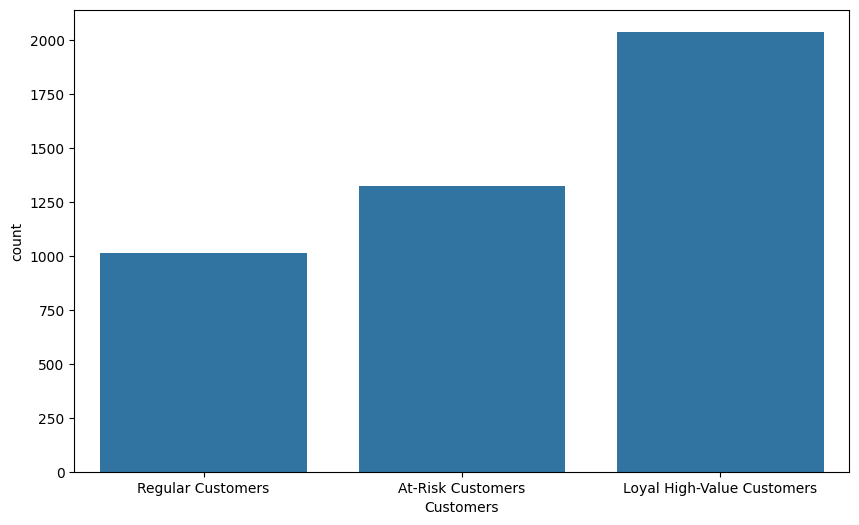

In [46]:
plt.figure(figsize=(10,6))
sns.countplot(x='Segment',data=customer_df)
plt.xlabel("Customers")
plt.ylabel("count")
plt.show()

In [47]:
print(customer_df)

      CustomerID  Recency  Frequency  Monetary  TotalProducts  UniqueProducts  \
0          12346      326          0         0              2               1   
1          12347        2       2458      3012            182             103   
2          12348       75       2341       944             31              22   
3          12349       19        631      1404             73              73   
4          12350      310        197       244             17              17   
...          ...      ...        ...       ...            ...             ...   
4367       18280      278         45       142             10              10   
4368       18281      181         54        54              7               7   
4369       18282        8         98       130             13              12   
4370       18283        4       1357      1346            721             263   
4371       18287       43       1586      1136             70              59   

      InvoiceMonth  Invoice

In [48]:
cluster_profile=customer_df.groupby("Segment").agg({
    "Recency":"mean",
    "Frequency":"mean",
    "Monetary":"mean",
    "TotalProducts":"mean",
    "UniqueProducts":"mean"
}).round(2)
cluster_profile

,Recency,Frequency,Monetary,TotalProducts,UniqueProducts
Segment,,,,,
At-Risk Customers,28.00,2937.71,3569.21,229.35,136.71
Loyal High-Value Customers,95.55,410.23,479.49,43.45,38.16
Regular Customers,168.66,172.89,138.82,9.74,9.01


In [49]:
global_popularity=df['Description'].value_counts()
print(global_popularity)

Description
WHITE HANGING HEART T-LIGHT HOLDER     2058
REGENCY CAKESTAND 3 TIER               1894
JUMBO BAG RED RETROSPOT                1659
PARTY BUNTING                          1409
ASSORTED COLOUR BIRD ORNAMENT          1405
                                       ... 
LETTER "W" BLING KEY RING                 1
CROCHET LILAC/RED BEAR KEYRING            1
MIDNIGHT BLUE CRYSTAL DROP EARRINGS       1
BLACK VINT ART DEC CRYSTAL BRACELET       1
WHITE STONE/CRYSTAL EARRINGS              1
Name: count, Length: 3896, dtype: int64


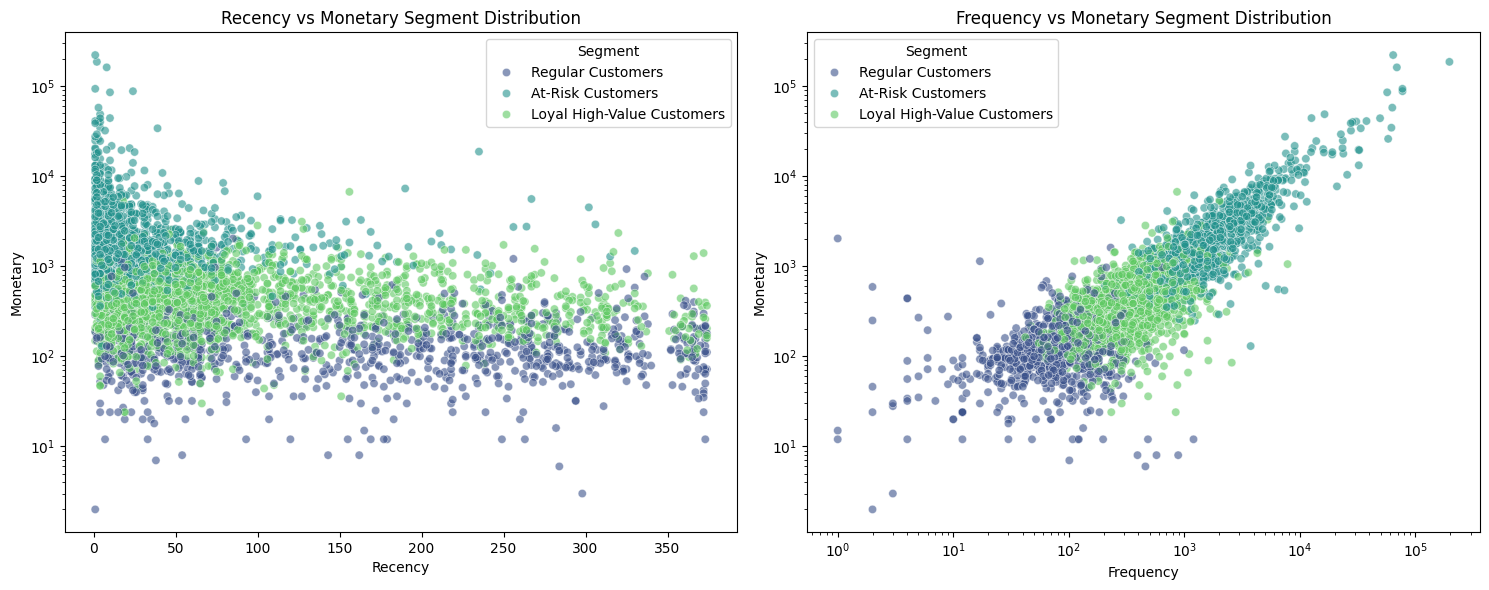

In [50]:
plt.figure(figsize=(15, 6))
# Plot 1: Recency vs Monetary
plt.subplot(1, 2, 1)
sns.scatterplot(data=customer_df, x='Recency', y='Monetary', hue='Segment', palette='viridis', alpha=0.6)
plt.title('Recency vs Monetary Segment Distribution')
plt.yscale('log') # Using log scale because Monetary values can vary widely

# Plot 2: Frequency vs Monetary
plt.subplot(1, 2, 2)
sns.scatterplot(data=customer_df, x='Frequency', y='Monetary', hue='Segment', palette='viridis', alpha=0.6)
plt.title('Frequency vs Monetary Segment Distribution')
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

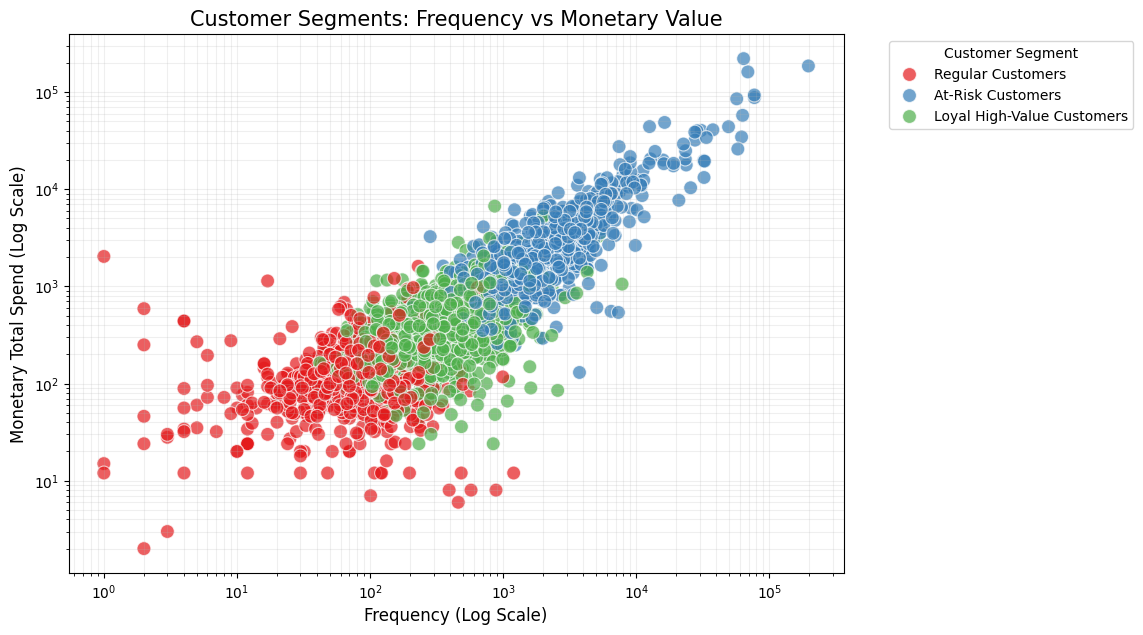

In [51]:
plt.figure(figsize=(10, 7))

# Creating the scatter plot
sns.scatterplot(
    data=customer_df,
    x='Frequency',
    y='Monetary',
    hue='Segment',
    palette='Set1',
    s=100,
    alpha=0.7
)

# Using log scales makes the clusters easier to see since data is often skewed
plt.xscale('log')
plt.yscale('log')

plt.title('Customer Segments: Frequency vs Monetary Value', fontsize=15)
plt.xlabel('Frequency (Log Scale)', fontsize=12)
plt.ylabel('Monetary Total Spend (Log Scale)', fontsize=12)
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

In [52]:
print(customer_df)

      CustomerID  Recency  Frequency  Monetary  TotalProducts  UniqueProducts  \
0          12346      326          0         0              2               1   
1          12347        2       2458      3012            182             103   
2          12348       75       2341       944             31              22   
3          12349       19        631      1404             73              73   
4          12350      310        197       244             17              17   
...          ...      ...        ...       ...            ...             ...   
4367       18280      278         45       142             10              10   
4368       18281      181         54        54              7               7   
4369       18282        8         98       130             13              12   
4370       18283        4       1357      1346            721             263   
4371       18287       43       1586      1136             70              59   

      InvoiceMonth  Invoice

In [53]:
global_popularity=df['Description'].value_counts()
print(global_popularity)

Description
WHITE HANGING HEART T-LIGHT HOLDER     2058
REGENCY CAKESTAND 3 TIER               1894
JUMBO BAG RED RETROSPOT                1659
PARTY BUNTING                          1409
ASSORTED COLOUR BIRD ORNAMENT          1405
                                       ... 
LETTER "W" BLING KEY RING                 1
CROCHET LILAC/RED BEAR KEYRING            1
MIDNIGHT BLUE CRYSTAL DROP EARRINGS       1
BLACK VINT ART DEC CRYSTAL BRACELET       1
WHITE STONE/CRYSTAL EARRINGS              1
Name: count, Length: 3896, dtype: int64


## 13. Cluster-level Recommendations
Popular products within each cluster are identified for segment-based recommendations.


In [54]:
def get_cluster_recommendations_customer_level(customer_id, top_n=5):
    # 1. Find cluster of this customer
    cluster_id = customer_df[customer_df['CustomerID']==customer_id]['Clusters'].values[0]

    # 2. Customers in same cluster
    customer_ids = customer_df[customer_df['Clusters']==cluster_id]['CustomerID']
    cluster_transactions = df[df['CustomerID'].isin(customer_ids)]

    # 3. Popular products in the cluster
    cluster_popularity = cluster_transactions['Description'].value_counts()

    # 4. Remove products already bought by this customer
    customer_products = df[df['CustomerID']==customer_id]['Description'].unique()
    cluster_popularity = cluster_popularity.drop(labels=customer_products, errors='ignore')

    # 5. Fallback if empty
    if cluster_popularity.empty:
        cluster_popularity = global_popularity.copy()

    # 6. Return top N products
    return cluster_popularity.head(top_n).index.tolist()



In [55]:
segment_recommendations = {}

for cluster_id, segment_name in cluster_names.items():
    # Take first 3 recommendations from **first customer** in the cluster as example
    first_customer_id = customer_df[customer_df['Clusters']==cluster_id]['CustomerID'].values[0]
    recs = get_cluster_recommendations_customer_level(first_customer_id, top_n=5)

    segment_recommendations[segment_name] = recs

    print(f"\nTop Recommendations for {segment_name} (personalized example):")
    print(recs)



Top Recommendations for Regular Customers (personalized example):
['WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER', 'POSTAGE', 'PARTY BUNTING', 'ASSORTED COLOUR BIRD ORNAMENT']

Top Recommendations for Loyal High-Value Customers (personalized example):
['WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER', 'ASSORTED COLOUR BIRD ORNAMENT', 'PARTY BUNTING', 'REX CASH+CARRY JUMBO SHOPPER']

Top Recommendations for At-Risk Customers (personalized example):
['WHITE HANGING HEART T-LIGHT HOLDER', 'JUMBO BAG RED RETROSPOT', 'LUNCH BAG RED RETROSPOT', 'PARTY BUNTING', 'ASSORTED COLOUR BIRD ORNAMENT']


In [56]:
customer_df['Recommended_Products'] = customer_df['CustomerID'].apply(
    lambda x: ", ".join(get_cluster_recommendations_customer_level(x, top_n=3))
)

print(customer_df[['CustomerID','Segment','Recommended_Products']].head())


   CustomerID                     Segment  \
0       12346           Regular Customers   
1       12347           At-Risk Customers   
2       12348  Loyal High-Value Customers   
3       12349           At-Risk Customers   
4       12350  Loyal High-Value Customers   

                                Recommended_Products  
0  WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CA...  
1  WHITE HANGING HEART T-LIGHT HOLDER, JUMBO BAG ...  
2  WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CA...  
3  WHITE HANGING HEART T-LIGHT HOLDER, JUMBO BAG ...  
4  WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CA...  


**User-User Collaborative Filtering**

In [57]:
#For calculating the rfm business problem we needed customer-level data
#To get particular products we are gain using transaction level data

customer_product_matrix=df.pivot_table(
    index='CustomerID',
    columns='Description',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)
print(customer_product_matrix)


# Calculate Cosine Similarity between users
print("Calculating User Similarities...")
user_similarity = cosine_similarity(customer_product_matrix)
print(user_similarity)
print("--------------------------------------------------------------------------------------")
similarity_df = pd.DataFrame(
    user_similarity,
    index=customer_product_matrix.index,
    columns=customer_product_matrix.index
)
print(similarity_df)



Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
CustomerID                                                                    
12346                                     0                               0   
12347                                     0                               0   
12348                                     0                               0   
12349                                     0                               0   
12350                                     0                               0   
...                                     ...                             ...   
18280                                     0                               0   
18281                                     0                               0   
18282                                     0                               0   
18283                                     0                               0   
18287                                     0         

In [58]:
def get_user_similarity_recommendations(customer_id, top_n=5):
    # 1. Get similarity scores for this customer
    sim_scores = similarity_df.loc[customer_id]

    # 2. Exclude self, sort by similarity
    sim_scores = sim_scores.drop(customer_id).sort_values(ascending=False)

    # 3. Take top 3 most similar customers
    top_customers = sim_scores.head(3).index

    # 4. Get products bought by similar customers
    similar_products = df[df['CustomerID'].isin(top_customers)]['Description']

    # 5. Remove products already bought by this customer
    already_bought = df[df['CustomerID']==customer_id]['Description'].unique()
    recommendations = similar_products[~similar_products.isin(already_bought)]

    # 6. Return top N popular products
    return recommendations.value_counts().head(top_n).index.tolist()


Hybrid Recommendation System

In [59]:
# 1. Improved User-User Similarity (Higher variety)
def get_user_similarity_recommendations(customer_id, top_n=5):
    # Get similarity scores
    sim_scores = similarity_df.loc[customer_id]
    # Exclude self and take top 15 neighbors instead of just 3 for more variety
    sim_scores = sim_scores.drop(customer_id).sort_values(ascending=False)
    top_customers = sim_scores.head(15).index

    # Get products bought by these specific similar neighbors
    similar_products = df[df['CustomerID'].isin(top_customers)]['Description']

    # Filter out what the customer already bought
    already_bought = df[df['CustomerID']==customer_id]['Description'].unique()
    recommendations = similar_products[~similar_products.isin(already_bought)]

    # Return top N products unique to this user's circle
    return recommendations.value_counts().head(top_n).index.tolist()

# 2. Hybrid Logic: Personal First, Cluster Second
def get_hybrid_recommendations(customer_id, top_n=5):
    # FIRST PRIORITY: Personal recommendations (highly specific to the user)
    user_recs = get_user_similarity_recommendations(customer_id, top_n=top_n)

    # SECOND PRIORITY: Cluster popularity (the safety net)
    cluster_recs = get_cluster_recommendations_customer_level(customer_id, top_n=top_n)

    # Combine them
    hybrid_recs = user_recs.copy()

    # Fill remaining slots with cluster items if user_recs were fewer than top_n
    for item in cluster_recs:
        if item not in hybrid_recs:
            hybrid_recs.append(item)
        if len(hybrid_recs) >= top_n:
            break

    # Final Fallback: If still empty, use global top sellers
    if len(hybrid_recs) < top_n:
        global_top = global_popularity.head(10).index.tolist()
        for item in global_top:
            if item not in hybrid_recs and item not in hybrid_recs:
                hybrid_recs.append(item)
            if len(hybrid_recs) >= top_n:
                break

    return hybrid_recs

# 3. Apply the updated logic
customer_df['Hybrid_Recommendations'] = customer_df['CustomerID'].apply(
    lambda x: ", ".join(get_hybrid_recommendations(x, top_n=5))
)

# Display result to verify variety
print(customer_df[['CustomerID','Segment','Hybrid_Recommendations']].head(10))

   CustomerID                     Segment  \
0       12346           Regular Customers   
1       12347           At-Risk Customers   
2       12348  Loyal High-Value Customers   
3       12349           At-Risk Customers   
4       12350  Loyal High-Value Customers   
5       12352           At-Risk Customers   
6       12353           Regular Customers   
7       12354  Loyal High-Value Customers   
8       12355  Loyal High-Value Customers   
9       12356           At-Risk Customers   

                              Hybrid_Recommendations  
0  REGENCY CAKESTAND 3 TIER, 60 TEATIME FAIRY CAK...  
1  POSTAGE, ROUND SNACK BOXES SET OF4 WOODLAND , ...  
2  REGENCY CAKESTAND 3 TIER, PACK OF 72 RETROSPOT...  
3  STRAWBERRY CERAMIC TRINKET BOX, 60 TEATIME FAI...  
4  GARDENERS KNEELING PAD KEEP CALM , TRADITIONAL...  
5  ALARM CLOCK BAKELIKE PINK, STRAWBERRY FAIRY CA...  
6  STRAWBERRY CERAMIC TRINKET BOX, REGENCY CAKEST...  
7  GREEN POLKADOT PLATE , SET/6 RED SPOTTY PAPER ...  
8  WOODEN

In [60]:
customer_df['Hybrid_Recommendations'] = customer_df['CustomerID'].apply(
    lambda x: ", ".join(get_hybrid_recommendations(x, top_n=5))
)
customer_df[['CustomerID','Segment','Hybrid_Recommendations']].tail(25)


,CustomerID,Segment,Hybrid_Recommendations
4347,18251,Loyal High-Value Customers,"REGENCY CAKESTAND 3 TIER, JAM MAKING SET PRINT..."
4348,18252,Loyal High-Value Customers,"SMALL GLASS HEART TRINKET POT, ALARM CLOCK BAK..."
4349,18255,Regular Customers,"VICTORIAN GLASS HANGING T-LIGHT, SINGLE HEART ..."
4350,18256,Regular Customers,"GARDENERS KNEELING PAD KEEP CALM , RECIPE BOX ..."
4351,18257,At-Risk Customers,"JUMBO BAG BAROQUE BLACK WHITE, JUMBO BAG PINK..."
4352,18259,Loyal High-Value Customers,"SMALL GLASS HEART TRINKET POT, ALARM CLOCK BAK..."
4353,18260,At-Risk Customers,"CREAM SWEETHEART MINI CHEST, JAM MAKING SET PR..."
4354,18261,Loyal High-Value Customers,"FELTCRAFT 6 FLOWER FRIENDS, PINK FLORAL FELTCR..."
4355,18262,Regular Customers,"REGENCY CAKESTAND 3 TIER, PACK OF 60 PINK PAIS..."
4356,18263,At-Risk Customers,"ENGLISH ROSE HOT WATER BOTTLE, WHITE HANGING H..."


In [61]:
#For loading the data files into Power bi
from google.colab import files
df.to_csv("transactions.csv", index=False)
customer_df.to_csv("customer_segments.csv", index=False)
files.download("customer_segments.csv")
files.download("transactions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

This project successfully demonstrates how customer transaction data can be transformed into actionable insights using clustering and recommendation techniques. The combined use of behavioral segmentation and a hybrid recommendation system enables data-driven decision-making for targeted marketing and improved customer engagement.
